In [1]:
import pandas as pd   ###variationalinference1init
import math, random
all_data  = pd.read_csv("sensor_data_600.txt", delimiter=" ", header=None, names = ("date","time","ir","z"))#lidarのセンサ値は「z」に
data = all_data.sample(1000).sort_values(by="z").reset_index()  #1000個だけサンプリングしてインデックスを振り直す
data = pd.DataFrame(data["z"])

display(data[0:3], data[-4:-1]) #とりあえず最初と最後のデータを表示

,z
0,610
1,613
2,613


,z
996,640
997,640
998,640


In [2]:
##負担率の初期化## ###variationalinference1rate

K = 2 #クラスタ数
n = int(math.ceil(len(data)/K)) #クラスタあたりのセンサ値の数
for k in range(K):
    data[k] = [1.0 if k == int(i/n) else 0.0 for i,d in data.iterrows()] #データをK個に分けて、一つのr_{i,k}を1に。他を0に。
    
display(data[0:3], data[-4:-1])  #下の出力の「0」、「1」が負担率の列

,z,0,1
0,610,1.0,0.0
1,613,1.0,0.0
2,613,1.0,0.0


,z,0,1
996,640,0.0,1.0
997,640,0.0,1.0
998,640,0.0,1.0


In [3]:
def update_parameters(ds, k, mu_avg=600, zeta=1, alpha=1, beta=1, tau=1):    ###variationalinference1params
    R = sum([d[k] for _, d in ds.iterrows()])
    S = sum([d[k]*d["z"] for _, d in ds.iterrows()])
    T = sum([d[k]*(d["z"]**2) for _, d in ds.iterrows()])
    
    hat = {}

    hat["tau"] = R + tau
    hat["zeta"] = R + zeta
    hat["mu_avg"] = (S + zeta*mu_avg)/hat["zeta"]
    hat["alpha"] = R/2 + alpha
    hat["beta"] = (T + zeta*(mu_avg**2) - hat["zeta"]*(hat["mu_avg"]**2))/2 + beta
    
    hat["z_std"] = math.sqrt(hat["beta"]/hat["alpha"])
    
    return pd.DataFrame(hat, index=[k])

In [4]:
params = pd.concat([update_parameters(data, k) for k in range(K)])   ###variationalinference1paramsolve
params

,tau,zeta,mu_avg,alpha,beta,z_std
0,501.0,501.0,622.093812,251.0,3046.295409,3.483767
1,501.0,501.0,631.918164,251.0,2604.822355,3.221456


In [5]:
from scipy.stats import norm, dirichlet ###variationalinference1draw
import matplotlib.pyplot as plt
import numpy as np

def draw(ps):
    pi = dirichlet([ps["tau"][k] for k in range(K)]).rvs()[0]
    pdfs = [ norm(loc=ps["mu_avg"][k], scale=ps["z_std"][k]) for k in range(K) ]

    xs = np.arange(600,650,0.5)

    ##p(z)の描画##
    ys = [ sum([pdfs[k].pdf(x)*pi[k] for k in range(K)])*len(data) for x in xs] #pdfを足してデータ数をかける
    plt.plot(xs, ys, color="red")

    ##各ガウス分布の描画##
    for k in range(K):
        ys = [pdfs[k].pdf(x)*pi[k]*len(data) for x in xs]
        plt.plot(xs, ys, color="blue")

    ##元のデータのヒストグラムの描画##
    data["z"].hist(bins = max(data["z"]) - min(data["z"]), align='left', alpha=0.4, color="gray")
    plt.show()

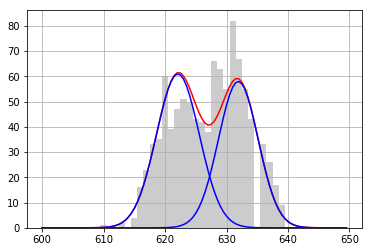

In [6]:
draw(params) ###variationalinference1graph

In [7]:
from scipy.special import digamma  ###variationalinference1responsibility

def responsibility(z, K, ps):
    tau_sum = sum([ps["tau"][k] for k in range(K)])
    r = {}
    for k in range(K):
        log_rho = (digamma(ps["alpha"][k]) - math.log(ps["beta"][k]))/2 \
                            - (1/ps["zeta"][k] + ((ps["mu_avg"][k] - z)**2)*ps["alpha"][k]/ps["beta"][k])/2 \
                            + digamma(ps["tau"][k]) - digamma(tau_sum)
                
        r[k] = math.exp(log_rho)
       
    w = sum([ r[k] for k in range(K) ]) #正規化
    for k in range(K): r[k] /= w
    
    return r

In [8]:
rs = [responsibility(d["z"], K, params) for _, d in data.iterrows() ] ###variationalinference1calcr

for k in range(K):
    data[k] = [rs[i][k] for i,_ in data.iterrows()]
    
display(data[0:3], data[len(data)//2:len(data)//2+3], data[-4:-1]) #データの先頭、中盤、後ろを表示

,z,0,1
0,610,1.000000,3.969494e-08
1,613,0.999999,1.058971e-06
2,613,0.999999,1.058971e-06


,z,0,1
500,628,0.315243,0.684757
501,628,0.315243,0.684757
502,628,0.315243,0.684757


,z,0,1
996,640,0.000039,0.999961
997,640,0.000039,0.999961
998,640,0.000039,0.999961
